In [1]:
import os
import time
import pickle
import torch
import torch.nn as nn
import numpy as np
import scipy
from scipy import special, integrate, optimize, stats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import gaussian_preact as gpre
from gaussian_preact import ParameterizedFunction, Integrand, find_density

torch.set_default_dtype(torch.float64)

In [2]:
theta = 4.
lambd = 1.
theta_conj = 1/(1/2 - 1/theta)
alpha = 3.
lambd_1 = 1.
lambd_2 = 1.
gamma = 1.

surv_kernel_Weib = gpre.build_surv_kernel_Weib(theta, lambd)

density = ParameterizedFunction(theta, theta_conj, alpha, lambd_1, lambd_2, gamma)
integrand = Integrand(density, surv_kernel_Weib)

In [3]:
z = 1

intervals, dxs, value = integrand.compute_intervals(z, 0, 10, 50)
print(integrand.integrate(z, intervals, dxs).item())
print(value)

0.3198478246627189
0.31980594215532643


In [4]:
dct_densities = {}

In [5]:
# Set the initial parameters of the density
theta = 4.
lambd = 1.
alpha = 3.
lambd_1 = 1.
lambd_2 = 1.
gamma = 1.

# Build the dataset
zmin = 0
zmax = 5
znum = 200
inputs = torch.linspace(zmin, zmax, znum)
targets = gpre.surv_Gaussian_abs(inputs)

In [6]:
# Optimization parameters
lr = .01
epochs = 600

In [7]:
dct_densities = {}
dct_losses = {}

In [ ]:
for theta in [2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]:
    # Initialize objects depending on theta
    theta_conj = theta_conj = 1/(1/2 - 1/theta)
    surv_kernel_Weib = gpre.build_surv_kernel_Weib(theta, lambd)
    density = ParameterizedFunction(theta, theta_conj, alpha, lambd_1, lambd_2, gamma)
    integrand = Integrand(density, surv_kernel_Weib)
    
    # Train and get the final density
    dct_densities[theta], dct_losses = find_density(theta, surv_kernel_Weib, density, integrand,
            inputs, targets, lr = lr, epochs = epochs, scipy_update_period = 50, theta_conj_phases = 2)

    epoch 0 ; loss: 0.407570
    epoch 50 ; loss: 0.062789
    epoch 100 ; loss: 0.011525
    epoch 150 ; loss: 0.005541
    epoch 200 ; loss: 0.002807
    epoch 250 ; loss: 0.001914
    epoch 300 ; loss: 0.001192
    epoch 350 ; loss: 0.001888
    epoch 400 ; loss: 0.001186
    epoch 450 ; loss: 0.001102
    epoch 500 ; loss: 0.001084
    epoch 550 ; loss: 0.001079
    epoch 599 ; loss: 0.001074
Final loss: 0.001074
    epoch 0 ; loss: 0.416691
    epoch 50 ; loss: 0.059917
    epoch 100 ; loss: 0.009361
    epoch 150 ; loss: 0.003693
    epoch 200 ; loss: 0.001765
    epoch 250 ; loss: 0.001810
    epoch 300 ; loss: 0.001377
    epoch 350 ; loss: 0.001820
    epoch 400 ; loss: 0.001079
    epoch 450 ; loss: 0.001464
    epoch 500 ; loss: 0.001019
    epoch 550 ; loss: 0.000988
    epoch 599 ; loss: 0.000987
Final loss: 0.000985
    epoch 0 ; loss: 0.433488
    epoch 50 ; loss: 0.064109
    epoch 100 ; loss: 0.011092
    epoch 150 ; loss: 0.003990
    epoch 200 ; loss: 0.002672
    ep

In [6]:
# Solve integral equation
restart = False
cfg = 'cfg4c'
path_store = './'

zmin = 0
zmax = 5
znum = 200
max_err = .015

lr = .01
epochs = 100

#fs_name = 'InvInt_dens_' + cfg + '_theta-{:.4f}_err-{:.2e}_zmin-{:.2e}_zmax-{:.2e}_znum-{}_.pkl'
#func_cfg = globals()['find_density_' + cfg]
lst_theta = [2.05] #[2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]

dct_f_approx = {}

for theta in lst_theta:
    dct_densities[theta], err = find_density(theta, zmin, zmax, znum, lr = lr, epochs = epochs)

    """pickle.dump({'approx': approx, 'err': err}, \
        file = open(path_store + fs_density_func.build_fname(theta, err, zmin, zmax, znum), 'wb'))"""

    epoch 0 ; loss: 0.407570
    epoch 50 ; loss: 0.074129
    epoch 99 ; loss: 0.013296
Final loss: 0.013083


In [344]:
# Solve integral equation
restart = False
cfg = 'cfg4c'
path_store = './'

zmin = 0
zmax = 5
znum = 200
max_err = .015

lr = .01
epochs = 600

fs_name = 'InvInt_dens_' + cfg + '_theta-{:.4f}_err-{:.2e}_zmin-{:.2e}_zmax-{:.2e}_znum-{}_.pkl'
func_cfg = globals()['find_density_' + cfg]
lst_theta = [4.] #[2.05, 2.1, 2.2, 2.5, 3., 4., 5., 6., 7., 8., 9., 10.]

dct_f_approx = {}

for theta in lst_theta:
    dct_densities[theta], err = func_cfg(theta, max_err, zmin, zmax, znum, lr = lr, epochs = epochs)

    """pickle.dump({'approx': approx, 'err': err}, \
        file = open(path_store + fs_density_func.build_fname(theta, err, zmin, zmax, znum), 'wb'))"""

    epoch 0 ; loss: 0.577068
    epoch 50 ; loss: 0.095404
    epoch 100 ; loss: 0.004507
    epoch 150 ; loss: 0.002852
    epoch 200 ; loss: 0.002652
    epoch 250 ; loss: 0.004945
    epoch 300 ; loss: 0.006938
    epoch 350 ; loss: 0.008153
    epoch 400 ; loss: 0.009657
    epoch 450 ; loss: 0.009589
    epoch 500 ; loss: 0.008657
    epoch 550 ; loss: 0.008072
    epoch 599 ; loss: 0.008005


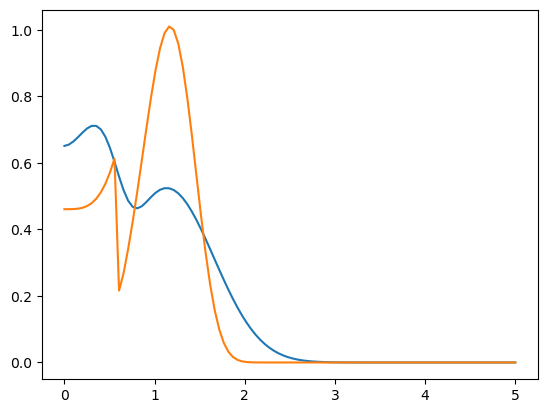

In [17]:
with torch.no_grad():
    for theta, density in dct_densities.items():
        plt.plot(np.linspace(0, 5, 100), density(torch.linspace(0, 5, 100)), 
                 label = r'$\theta = {:.2f}$'.format(theta))

In [346]:
pickle.dump(dct_densities, open('dct_densities.pkl', 'wb'))

In [19]:
dct_densities_load = pickle.load(open('dct_densities.pkl', 'rb'))

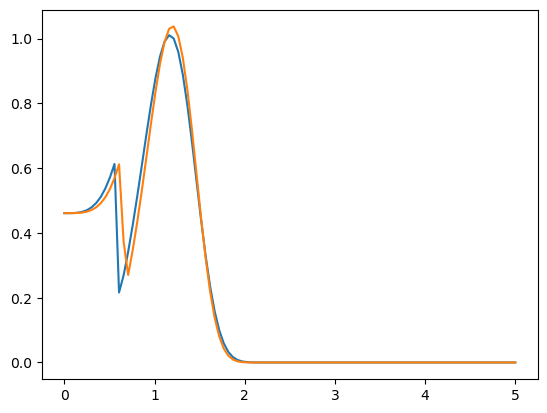

In [21]:
with torch.no_grad():
    plt.plot(np.linspace(0, 5, 100), dct_densities[2.05](torch.linspace(0, 5, 100)))
    plt.plot(np.linspace(0, 5, 100), dct_densities_load[2.05](torch.linspace(0, 5, 100)))

In [24]:
dct_densities[2.05].lambd_2

Parameter containing:
tensor(0.5962, requires_grad=True)

In [25]:
dct_densities_load[2.05].lambd_2

Parameter containing:
tensor(0.6565, dtype=torch.float32, requires_grad=True)

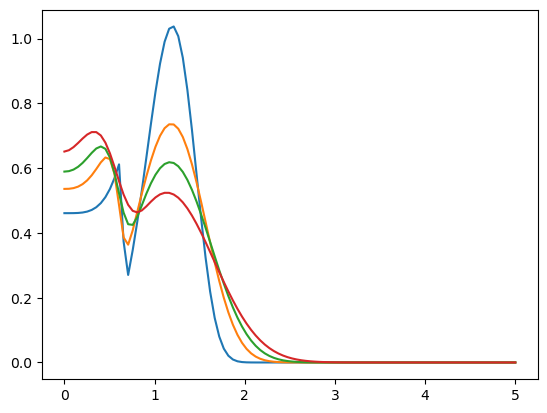

In [20]:
with torch.no_grad():
    for theta, density in dct_densities_load.items():
        plt.plot(np.linspace(0, 5, 100), density(torch.linspace(0, 5, 100)), 
                 label = r'$\theta = {:.2f}$'.format(theta))